# King County House Sales Data Exploration, Analysis, & Modeling
### Kevin Velasco & Alex Shropshire

#### Imports

In [1]:
#PANDAS, NUMPY, MATPLOTLIB, SEABORN, MATH
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from math import sqrt

#STATSMODELS
import statsmodels.api as sm
from statsmodels.formula.api import ols

#SCI-KIT LEARN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error

#### Data Loading

In [2]:
house_df = pd.read_csv('kc_house_data.csv')
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


#### Initial Correlation Analysis

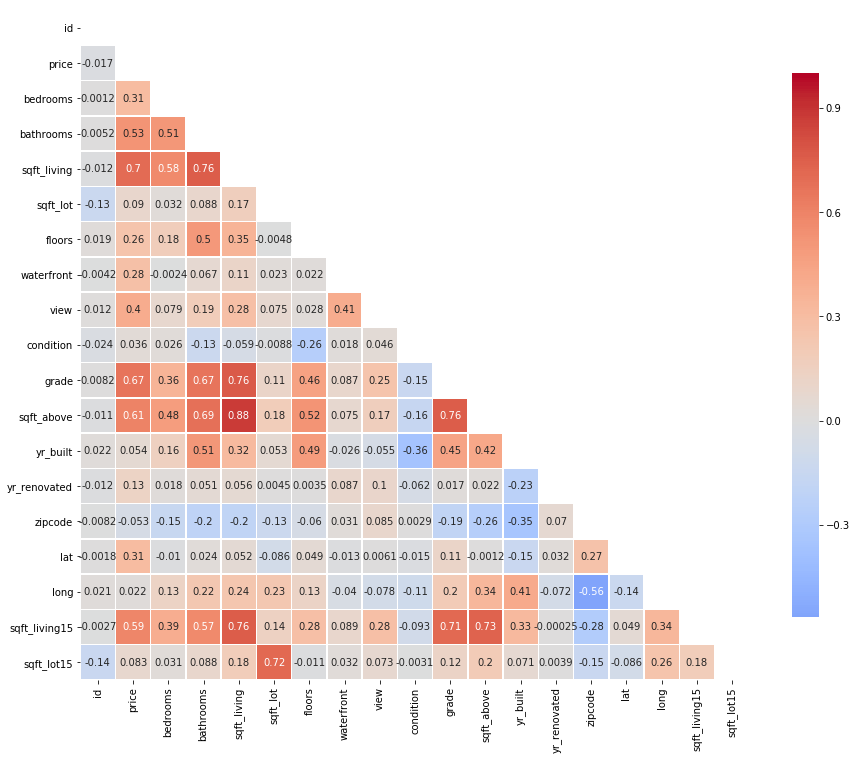

In [3]:
corr = house_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

- The darkest red outputs illustrate the strongest positive linear relationships as far as we can tell strictly from correlation coefficients(r), and the darkest blue values are the negative linear relationships.
- The values that describe each house's size & condition are often strongly correlated with each other. 
- The variables that are square footage-specific seem to show a very similar relationship with each other and price.


#### Data Cleaning Notes:
- set waterfront nulls to 0, assumption: nulls mean there is no waterfront view
- set view nulls to 0, assumption: nulls mean nobody has viewed
- set yr_renovated 0's to nulls, assumption: 0 = no renovation has been done
- set sqft_basement '0's & '?' to null, assumption: 0 & ? means no basement exists
- Change date to type datetime64 using pd.Timestamp
- Change zipcode to type str
- Change sqft_basement to type float

In [4]:
house_dff = house_df #to keep integrity of original dataframe, we'll manipulate a copy

In [5]:
#1) Set waterfront nulls to 0, assumption: nulls mean there is no waterfront view
house_dff['waterfront'] = house_dff['waterfront'].fillna(0)

#2) set view nulls to 0, assumption: nulls mean nobody has viewed
house_dff['view'] = house_dff['view'].fillna(0)

#3) set yr_renovated 0's to nulls, assumption: 0 = no renovation has been done
house_dff['yr_renovated'] = house_dff['yr_renovated'].replace(0,np.nan)

#4) set sqft_basement '0's & '?' to null, assumption: 0 & ? means no basement exists. values are in str format
house_dff['sqft_basement'] = house_dff['sqft_basement'].replace('0.0',np.nan)
house_dff['sqft_basement'] = house_dff['sqft_basement'].replace('?',np.nan)

#5) Change date to type datetime64 using pd.Timestamp
house_dff.date = house_dff.date.apply(pd.Timestamp)

#6) Change zipcode to type str
house_dff.zipcode = house_dff.zipcode.astype(str)

#7) Change sqft_basement to type float
house_dff['sqft_basement'] = house_dff['sqft_basement'].astype(float)

In [6]:
#View information of new dataframe house_dff after cleaning steps were completed
house_dff.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,NaN,1955,NaN,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,NaN,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,NaN,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,NaN,1987,NaN,98074,47.6168,-122.045,1800,7503


#### Initial Visualizations: 
1) Histograms of x-variables 

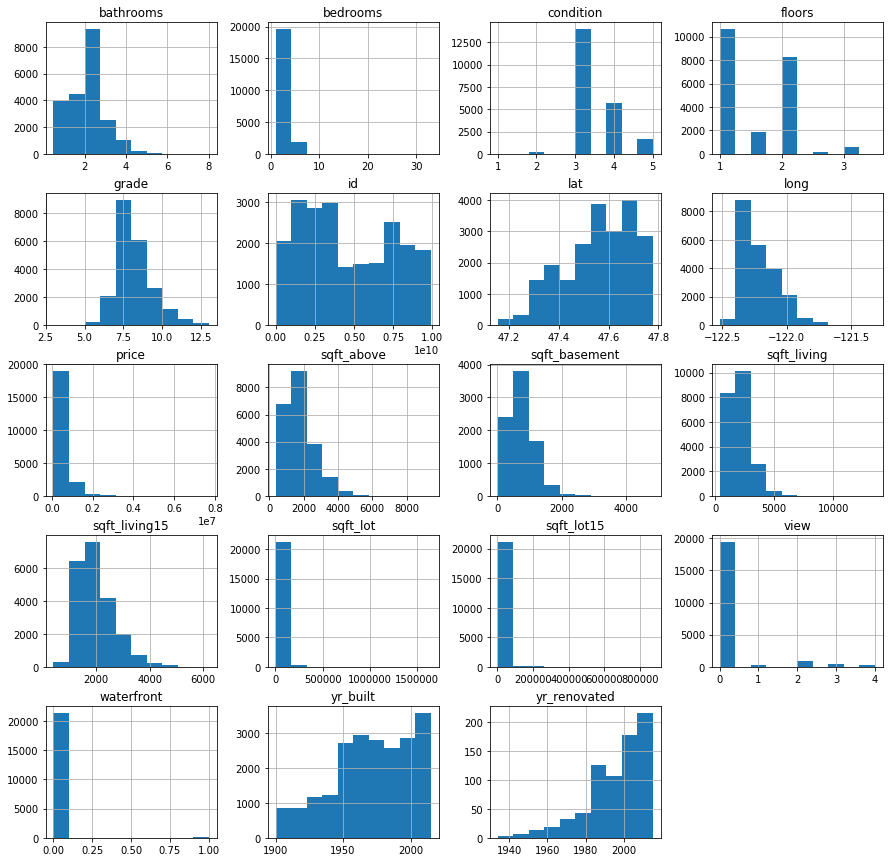

In [7]:
#Plot histograms of our x variables
house_dff.hist(figsize=[15,15]);

#### Initial Visualizations: 
2) Simple Linear Regression Top x-variables vs. Price (y) & R-Squared values

R-squared: 0.49268789904035104


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


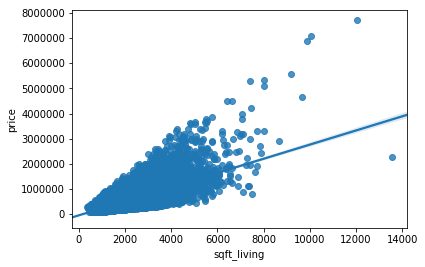

In [8]:
#POTENTIAL TOP 8 FEATURES (inferred from strength of correlation) PLOTTED
y = house_dff['price']
sqft_living_x = house_dff['sqft_living']
model = ols(formula = "y~sqft_living_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='sqft_living', y='price', data=house_dff); #r=0.7

R-squared: 0.44615823299735025


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


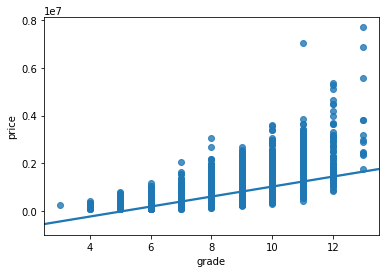

In [9]:
grade_x = house_dff['grade']
model = ols(formula = "y~grade_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='grade', y='price', data=house_dff); #r=0.67

R-squared: 0.3664703472658384


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


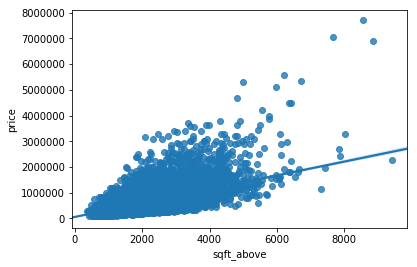

In [10]:
sqft_above_x = house_dff['sqft_above']
model = ols(formula = "y~sqft_above_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='sqft_above', y='price', data=house_dff); #r=0.61

R-squared: 0.3425072641720194


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


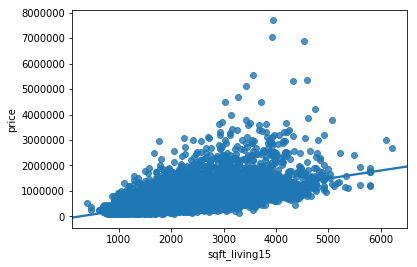

In [11]:
sqft_living15_x = house_dff['sqft_living15']
model = ols(formula = "y~sqft_living15_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='sqft_living15', y='price', data=house_dff);#r=0.59

R-squared: 0.27657672267607736


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


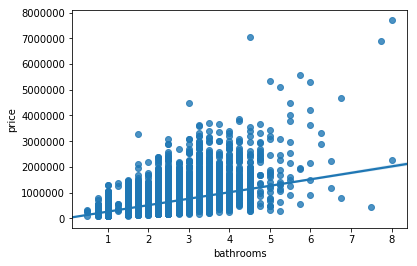

In [12]:
bathrooms_x = house_dff['bathrooms']
model = ols(formula = "y~bathrooms_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='bathrooms', y='price', data=house_dff);#r=0.53

R-squared: 0.154839628812666


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


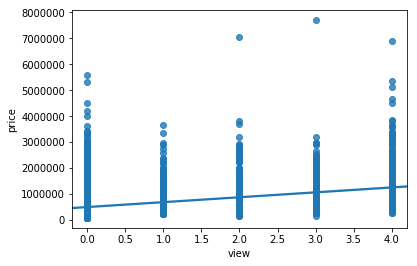

In [13]:
view_x = house_dff['view']
model = ols(formula = "y~view_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='view', y='price', data=house_dff);#r=0.4

R-squared: 0.09534970283730637


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


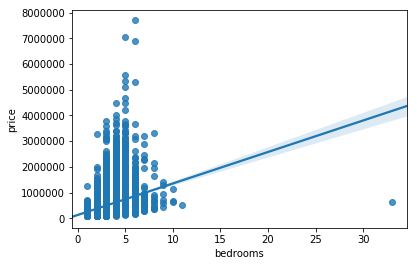

In [14]:
bedrooms_x = house_dff['bedrooms']
model = ols(formula = "y~bedrooms_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='bedrooms', y='price', data=house_dff);#r=0.31

R-squared: 0.09406017561856983


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


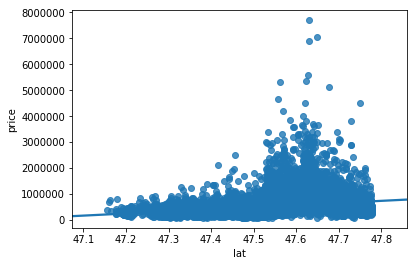

In [15]:
lat_x = house_dff['lat']
model = ols(formula = "y~lat_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='lat', y='price', data=house_dff);#r=0.31

In [16]:
house_dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    8317 non-null float64
yr_built         21597 non-null int64
yr_renovated     744 non-null float64
zipcode          21597 non-null object
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(10), object(1)
memory u

#### Initial Feature Engineering & Quickly Testing Potential Relationship with Home Price (y)

- Combining # of beds + baths to a single digit
- Creating a binary (yes or no) of whether or not the house was renovated at all
- Combining through addition the square footage of living quarters and the entire lot
- Combining through addition the square footage of living quarters and the entire lot OF CLOSE NEIGHBORS

In [17]:
#Combining # of beds + baths to a single digit
house_dff['bed_bath_sum'] = house_dff['bedrooms'] + house_dff['bathrooms']

R-squared: 0.21843993553827934


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


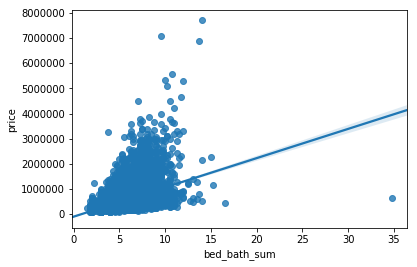

In [18]:
#Testing new feature: bed_bath_sum
bed_bath_sum_x = house_dff['bed_bath_sum']
model = ols(formula = "y~bed_bath_sum_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='bed_bath_sum', y='price', data=house_dff);

In [19]:
#Creating a binary (yes or no) of whether or not the house was renovated at all
house_dff['renovation_yes'] = (~np.isnan(house_dff['yr_renovated'])).astype(int)

R-squared: 0.013816377301946403


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


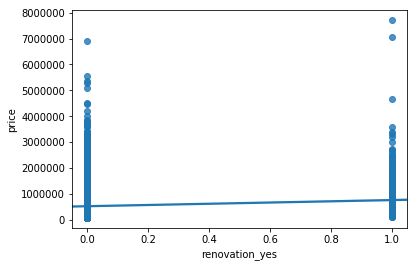

In [20]:
#Testing new feature: renovation_yes
renovation_yes_x = house_dff['renovation_yes']
model = ols(formula = "y~renovation_yes_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='renovation_yes', y='price', data=house_dff);

In [21]:
#Combining through addition the square footage of living quarters and the entire lot
house_dff['sqft_living_plus_lot'] = house_dff['sqft_living'] + house_dff['sqft_lot']

R-squared: 0.011026846496555498


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


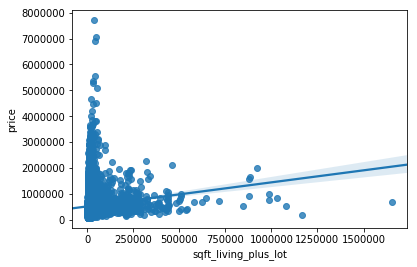

In [22]:
#Testing new feature: sqft_living_plus_lot
sqft_living_plus_lot_x = house_dff['sqft_living_plus_lot']
model = ols(formula = "y~sqft_living_plus_lot_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='sqft_living_plus_lot', y='price', data=house_dff);

In [23]:
#Combining through addition the square footage of living quarters and the entire lot OF CLOSE NEIGHBORS
house_dff['sqft_living_plus_lot_15'] = house_dff['sqft_living15'] + house_dff['sqft_lot15']

R-squared: 0.009422826639618465


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


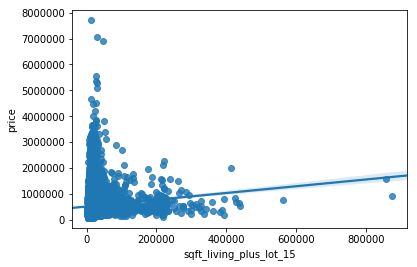

In [24]:
#Testing new feature: sqft_living_plus_lot15
sqft_living_plus_lot_15_x = house_dff['sqft_living_plus_lot_15']
model = ols(formula = "y~sqft_living_plus_lot_15_x", data=house_dff).fit()
print(f"R-squared: {model.rsquared}")
#PLOT
sns.regplot(x='sqft_living_plus_lot_15', y='price', data=house_dff);

##### Initial Feature Engineering Insights:

- Comments
- About new features
- Here

#### Creating MLR Output & Error Functions for Reproduceability (when y='price')

In [25]:
def statsmodels_lin_regress_summary(df):
    '''Outputs Regression Summary via Statsmodels given a DataFrame'''
    X = df.drop(['log_price','price'], axis=1)
    y = df.log_price
    predictors = np.asarray(X) #set predictors as numpy array of capital X
    predictors_int = sm.add_constant(predictors) #.add_constant
    model = sm.OLS(y,predictors_int).fit() #statsmodels.OrdinaryLeastSquares (dependent var, array of predictors).fit()
    print(f'Our list of predictors: {X.columns}')
    print(model.summary())

In [26]:
def sklearn_lin_regress_summary(df):
    '''Outputs R-squared & Error Metrics via sklearn given a DataFrame'''
    #applies every x-var except price & log_price to X variable list
    X = df.drop(['log_price','price'], axis=1)
    #sets target variable y to be log_price
    y = df.log_price
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    np.random.seed(33)
    X_train,X_test,y_train,y_test = train_test_split(X_scaled,y)
    lr = LinearRegression()
    lr.fit(X_train,y_train) #fit model
    coeff_array = lr.coef_
    r_2 = metrics.r2_score(y_test, lr.predict(X_test))
    mae = metrics.mean_absolute_error(np.exp(y_test), np.exp(lr.predict(X_test)))
    mse = metrics.mean_squared_error(np.exp(y_test), np.exp(lr.predict(X_test)))
    
    print("Results of Sklearn's Train-Test-Split below:")
    #print(f"Array of coefficients: {coeff_array}")
    print(f'Our list of predictors: {X.columns}')
    print(f"R-squared:{r_2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): ${sqrt(mse)}")

In [27]:
def kfolds(data, k):
    '''Splits dataset into k evenly or almost evenly sliced pieces'''
    #Force data as pandas dataframe
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

def k_folds_error_summary(df,k):
    '''Applies kfolds function to given dataframe, & outputs R-squared & key error metrics'''
    #applies every x-var except price & log_price to X variable list 
    X = df.drop(['log_price','price'], axis=1)
    #sets target variable y to be log_price
    y = df[['log_price']]
    k_folds_df = kfolds(df, k)
    MSE_test_errs = []
    MSE_train_errs = []
    MAE_test_errs = []
    MAE_train_errs = []
    k=k
    lr = LinearRegression()
    cv_k_results = cross_val_score(lr, X, y, cv=k, scoring="r2")
    for n in range(k):
        # Split in train and test for the fold
        train = pd.concat([fold for i, fold in enumerate(k_folds_df) if i!=n])
        test = k_folds_df[n]
        # Fit a linear regression model
        lr.fit(train[X.columns], train[y.columns])
        #Evaluate Train and Test Errors
        y_hat_train = lr.predict(train[X.columns])
        y_hat_test = lr.predict(test[X.columns])
        train_residuals = np.exp(y_hat_train) - np.exp(train[y.columns])
        test_residuals = np.exp(y_hat_test) - np.exp(test[y.columns])
        MSE_train_errs.append(np.mean(train_residuals.astype(float)**2))
        MSE_test_errs.append(np.mean(test_residuals.astype(float)**2))
        MAE_train_errs.append(np.mean(abs(train_residuals.astype(float))))
        MAE_test_errs.append(np.mean(abs(test_residuals.astype(float))))
    print(f'Our list of predictors: {X.columns}')
    print(f'Our R-Squared when k={k} is:{np.mean(cv_k_results)}')
    print(f" Our average training MAE when k={k} is:{np.mean(MAE_train_errs)}")
    #print(f" Our average test MAE when k={k} is:{np.mean(MAE_test_errs)}")
    print(f" Our average training MSE when k={k} is:{np.mean(MSE_train_errs)}")
    #print(f" Our average test MSE when k={k} is:{np.mean(MSE_test_errs)}")
    print(f" Our average training RMSE when k={k} is:{sqrt(np.mean(MSE_train_errs))}")
    #print(f" Our average test RMSE when k={k} is:{sqrt(np.mean(MSE_test_errs))}")

#### Benchmark Model: 1st Multiple Linear Regression using Top 6 Features

- We decided to make our first MLR model using the features that have the strongest relationship with price, by examining both the feature's R-squared output from each 2-variable Simple Linear Regression ran vs. Home Price, alongside its Pearson's correlation coefficient.
- Top 6 Features: 'sqft_living','grade','sqft_above','sqft_living15','bathrooms','view'
- We will use the model quality outputs from statsmodels, scikitlearn, and k-folds cross validation to assess each model improvement hereafter, with the below outputs as benchmarks going forward.

In [28]:
house_top6_df = house_dff[['price','sqft_living','grade','sqft_above','sqft_living15','bathrooms','view']]

- We decided to log transform our target variable price instead of simply using 'price', which is not normally distributed, in our first MLR
- log_price is a more useful target variable than price because the distribution of log_price is closer to normal than price, and the assumptions of linear regressions state that variables must be (at least almost) normally distributed
- A log transformation like this is quite typical to apply when the variable is not normally distributed

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


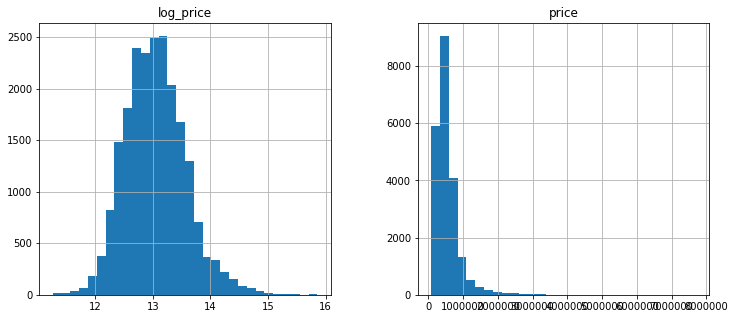

In [29]:
#LOG TRANSFORMATION OF PRICE
house_top6_df['log_price'] = np.log(house_top6_df['price'])
house_top6_df[['log_price', 'price']].hist(figsize=(12,5),bins=30);

In [30]:
#statsmodels output
statsmodels_lin_regress_summary(house_top6_df)

Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     5034.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:58:20   Log-Likelihood:                -7343.4
No. Observations:               21597   AIC:                         1.470e+04
Df Residuals:                   21590   BIC:                         1.476e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0

In [31]:
#sci-kit learn output
sklearn_lin_regress_summary(house_top6_df)

Results of Sklearn's Train-Test-Split below:
Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view'],
      dtype='object')
R-squared:0.5941566537740014
Mean Absolute Error (MAE): 145721.69281836363
Mean Squared Error (MSE): 49489790470.36296
Root Mean Squared Error (RMSE): $222463.0092180787


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
#k-folds cross validation output
k_folds_error_summary(house_top6_df,5)

Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view'],
      dtype='object')
Our R-Squared when k=5 is:0.5807327492042123
 Our average training MAE when k=5 is:146071.1318599893
 Our average training MSE when k=5 is:56550273327.67845
 Our average training RMSE when k=5 is:237803.01370604715


#### 1st MLR Benchmarks & Observations (Price vs. Top 6 Features)
###### Top 6: 'sqft_living','grade','sqft_above','sqft_living15','bathrooms','view'

###### R-squared Benchmarks:
- statsmodels R-squared: 0.58
- sci-kit learn R-squared: 0.59
- k=5 kfolds mean R-squared: 0.58

###### MAE Benchmarks:
- sci-kit learn MAE: 145,721
- k=5 kfolds mean MAE: 146,071

###### RMSE Benchmarks:
- sci-kit learn RMSE: 222,463
- k=5 kfolds mean RMSE: 237,803

###### Observations:
- SLR: Without taking into account multicollinearity, our our R-squared was small at **0.49**, MAE and MSE scores are massive! But its okay, this gives us a baseline of what to improve upon for our next model.
- MLR: By including our Top 6 variables instead of simply the sqft_living variable, we saw improvments in model quality in all 3 important metrics: R-squared, MAE, and MSE
- The improvement in R-Squared was small but decently significant, changing by 0.1, all before any modifications are made to our Multivariable model based on potential multicollinearity. We think that is the next best area to look into for an improved MLR model.

### MLR Model Improvement Tests

#### Test 1: dropping 'sqft_above'
###### sqft_above correlates highly (~0.8) with our strongest predictor sqft_living, and is a potential source of multicollinearity. We think dropping sqft_above will improve the model. Let's see what happens!

In [33]:
df1 = house_top6_df.drop(['sqft_above'], axis=1)
df1.head()

,price,sqft_living,grade,sqft_living15,bathrooms,view,log_price
0,221900.0,1180,7,1340,1.00,0.0,12.309982
1,538000.0,2570,7,1690,2.25,0.0,13.195614
2,180000.0,770,6,2720,1.00,0.0,12.100712
3,604000.0,1960,7,1360,3.00,0.0,13.311329
4,510000.0,1680,8,1800,2.00,0.0,13.142166


In [34]:
#statsmodels output
statsmodels_lin_regress_summary(df1)

Our list of predictors: Index(['sqft_living', 'grade', 'sqft_living15', 'bathrooms', 'view'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     5895.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:58:20   Log-Likelihood:                -7496.6
No. Observations:               21597   AIC:                         1.501e+04
Df Residuals:                   21591   BIC:                         1.505e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [35]:
#sci-kit learn output
sklearn_lin_regress_summary(df1)

Results of Sklearn's Train-Test-Split below:
Our list of predictors: Index(['sqft_living', 'grade', 'sqft_living15', 'bathrooms', 'view'], dtype='object')
R-squared:0.5868925696731291
Mean Absolute Error (MAE): 147108.20373288172
Mean Squared Error (MSE): 49398906678.23135
Root Mean Squared Error (RMSE): $222258.64815172288


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [36]:
#k-folds cross validation output
k_folds_error_summary(df1,5)

Our list of predictors: Index(['sqft_living', 'grade', 'sqft_living15', 'bathrooms', 'view'], dtype='object')
Our R-Squared when k=5 is:0.5747232810060648
 Our average training MAE when k=5 is:147381.34323857725
 Our average training MSE when k=5 is:56366428450.226524
 Our average training RMSE when k=5 is:237416.150356766


#### Test 1 Observations: dropping 'sqft_above'


###### Benchmark Errors (before):
- statsmodels R-squared: 0.58
- sci-kit learn R-squared: 0.59
- k=5 kfolds mean R-squared: 0.58
- sci-kit learn MAE: 145,721
- k=5 kfolds mean MAE: 146,071
- sci-kit learn RMSE: 222,463
- k=5 kfolds mean RMSE: 237,803

###### New Errors (after):
- statsmodels R-squared: 0.577
- sci-kit learn R-squared: 0.586
- k=5 kfolds mean R-squared: 0.575
- sci-kit learn MAE: 147,108
- k=5 kfolds mean MAE: 147,381
- sci-kit learn RMSE: 222,258
- k=5 kfolds mean RMSE: 237,416

###### Observations:
- Test 1 did not improve our model in R-squared or MAE, though RMSE improved very slightly. We will not be dropping sqft_above.

## Test 2: add in 'distance_from_flatiron' 
##### Our hypothesis is that home prices may have a linear relationship with the distance from the WeWork/Flatiron School building located in Downtown Seattle
##### New feature engineered from lat & long (see location_engineering.ipynb to see our detailed location data manipulation)

In [37]:
#data load with clean data
df = pd.read_csv('house_data_cleaned.csv')
#LOG TRANSFORMATION OF PRICE (log transformation necessary again due to a file saving mismatch)
df['log_price'] = np.log(df['price'])

In [38]:
df2 = df[['price','log_price','sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view','distance_from_flatiron']]

In [39]:
#statsmodels output
statsmodels_lin_regress_summary(df2)

Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view', 'distance_from_flatiron'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     8327.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:58:21   Log-Likelihood:                -2664.2
No. Observations:               21597   AIC:                             5344.
Df Residuals:                   21589   BIC:                             5408.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

In [40]:
#sci-kit learn output
sklearn_lin_regress_summary(df2)

Results of Sklearn's Train-Test-Split below:
Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view', 'distance_from_flatiron'],
      dtype='object')
R-squared:0.7390644544915168
Mean Absolute Error (MAE): 115458.45291912745
Mean Squared Error (MSE): 41271704009.65805
Root Mean Squared Error (RMSE): $203154.38466756768


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [41]:
#k-folds cross validation output
k_folds_error_summary(df2,5)

Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view', 'distance_from_flatiron'],
      dtype='object')
Our R-Squared when k=5 is:0.7280002364631583
 Our average training MAE when k=5 is:115209.49021053003
 Our average training MSE when k=5 is:39439956579.89895
 Our average training RMSE when k=5 is:198594.9560786954


## Test 2 Observations: adding distance_from_flatiron

###### Benchmark Errors (before):
- statsmodels R-squared: 0.58
- sci-kit learn R-squared: 0.59
- k=5 kfolds mean R-squared: 0.58
- sci-kit learn MAE: 145,721
- k=5 kfolds mean MAE: 146,071
- sci-kit learn RMSE: 222,463
- k=5 kfolds mean RMSE: 237,803

###### New Errors (after):
- statsmodels R-squared: 0.730
- sci-kit learn R-squared: 0.739
- k=5 kfolds mean R-squared: 0.728
- sci-kit learn MAE: 115,458
- k=5 kfolds mean MAE: 115,209
- sci-kit learn RMSE: 203,154
- k=5 kfolds mean RMSE: 198,594

###### Observations:
- Test 2 improved our model significantly in every key error metric, we should keep 'distance_from_flatiron' in our model.

## Test[3]: drop grade

###### 'grade' has high correlation with sqft_living (currently understood as our best predictor of price) and sqft_above (which Test 1 suggests we should keep in our model for now). Dropping grade may reduce our model's collinearity, let's try it!

In [42]:
df3 = df[['price','log_price','sqft_living', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view','distance_from_flatiron']]

In [43]:
#statsmodels output
statsmodels_lin_regress_summary(df3)

Our list of predictors: Index(['sqft_living', 'sqft_above', 'sqft_living15', 'bathrooms', 'view',
       'distance_from_flatiron'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     8591.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:58:21   Log-Likelihood:                -3617.0
No. Observations:               21597   AIC:                             7248.
Df Residuals:                   21590   BIC:                             7304.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|  

In [44]:
#sci-kit learn output
sklearn_lin_regress_summary(df3)

Results of Sklearn's Train-Test-Split below:
Our list of predictors: Index(['sqft_living', 'sqft_above', 'sqft_living15', 'bathrooms', 'view',
       'distance_from_flatiron'],
      dtype='object')
R-squared:0.7137892542212914
Mean Absolute Error (MAE): 123372.5161609515
Mean Squared Error (MSE): 67271643247.654755
Root Mean Squared Error (RMSE): $259367.7760394586


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [45]:
#k-folds cross validation output
k_folds_error_summary(df3,5)

Our list of predictors: Index(['sqft_living', 'sqft_above', 'sqft_living15', 'bathrooms', 'view',
       'distance_from_flatiron'],
      dtype='object')
Our R-Squared when k=5 is:0.7029777488490581
 Our average training MAE when k=5 is:121514.69096621065
 Our average training MSE when k=5 is:58542676341.33077
 Our average training RMSE when k=5 is:241955.938842862


## Test 3 Observations: dropping 'grade'

###### Benchmark Errors (before):
- statsmodels R-squared: 0.730
- sci-kit learn R-squared: 0.739
- k=5 kfolds mean R-squared: 0.728
- sci-kit learn MAE: 115,458
- k=5 kfolds mean MAE: 115,209
- sci-kit learn RMSE: 203,154
- k=5 kfolds mean RMSE: 198,594

###### New Errors (after):
- statsmodels R-squared: 0.705
- sci-kit learn R-squared: 0.714
- k=5 kfolds mean R-squared: 0.703
- sci-kit learn MAE: 123,373
- k=5 kfolds mean MAE: 121,515
- sci-kit learn RMSE: 259,368
- k=5 kfolds mean RMSE: 241,955

###### Observations:
- Test 3 did not improve our model in any key error metric, Test 2 still provides our best set of predictors

## Test 4: engineer & add 'yr_last_constructed'

In [46]:
#FEATURE ENGINEERING: 'yr_last_constructed'
#this new feature consolidates the most recent year between the yr_built column and the yr_renovated column
df['yr_last_constructed'] = df[['yr_built', 'yr_renovated']].max(axis=1)

In [47]:
#running new model quality test using the Test 2 Variables plus our new feature 'yr_last_constucted'
df4 = df[['price','log_price','sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view','distance_from_flatiron', 'yr_last_constructed']]

In [48]:
#statsmodels output
statsmodels_lin_regress_summary(df4)

Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view', 'distance_from_flatiron', 'yr_last_constructed'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     7468.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:58:21   Log-Likelihood:                -2468.6
No. Observations:               21597   AIC:                             4955.
Df Residuals:                   21588   BIC:                             5027.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef   

In [49]:
#sci-kit learn output
sklearn_lin_regress_summary(df4)

Results of Sklearn's Train-Test-Split below:
Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view', 'distance_from_flatiron', 'yr_last_constructed'],
      dtype='object')
R-squared:0.7438667987778227
Mean Absolute Error (MAE): 114682.47073920084
Mean Squared Error (MSE): 43661378918.29491
Root Mean Squared Error (RMSE): $208953.0543406698


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [50]:
#k-folds cross validation output
k_folds_error_summary(df4,5)

Our list of predictors: Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view', 'distance_from_flatiron', 'yr_last_constructed'],
      dtype='object')
Our R-Squared when k=5 is:0.7331342612881644
 Our average training MAE when k=5 is:114092.82908333612
 Our average training MSE when k=5 is:40112590560.07589
 Our average training RMSE when k=5 is:200281.27860605417


## Test 4 Observations: creating & adding 'yr_last_constructed' feature

###### Benchmark Errors (before):
- statsmodels R-squared: 0.730
- sci-kit learn R-squared: 0.739
- k=5 kfolds mean R-squared: 0.728
- sci-kit learn MAE: 115,458
- k=5 kfolds mean MAE: 115,209
- sci-kit learn RMSE: 203,154
- k=5 kfolds mean RMSE: 198,594

###### New Errors (after):
- statsmodels R-squared: 0.735
- sci-kit learn R-squared: 0.744
- k=5 kfolds mean R-squared: 0.733
- sci-kit learn MAE: 114,682
- k=5 kfolds mean MAE: 114,092
- sci-kit learn RMSE: 208,953
- k=5 kfolds mean RMSE: 200,281

###### Observations:
- Test 4 improved our model slightly. R-Squared & MAE both improved marginally, though our RMSE's worsened very slightly. Despite the results in opposing directions, we still think this is our best model thus far because we believe MAE is more of a priority than RMSE in this particular case because it is the most interpretable than RMSE, and consistently penalizes outliers & near-outliers regardless of location on the x-axis (unlike RMSE). We also believe that positive and negative errors should be treated equally, which MAE achieves.

## Variable Transformation Assessment: 
#### Below we assess the shape of current predictor variable distributions to look for candidates for transformations that would help us more closely meet the assumptions of linear regression

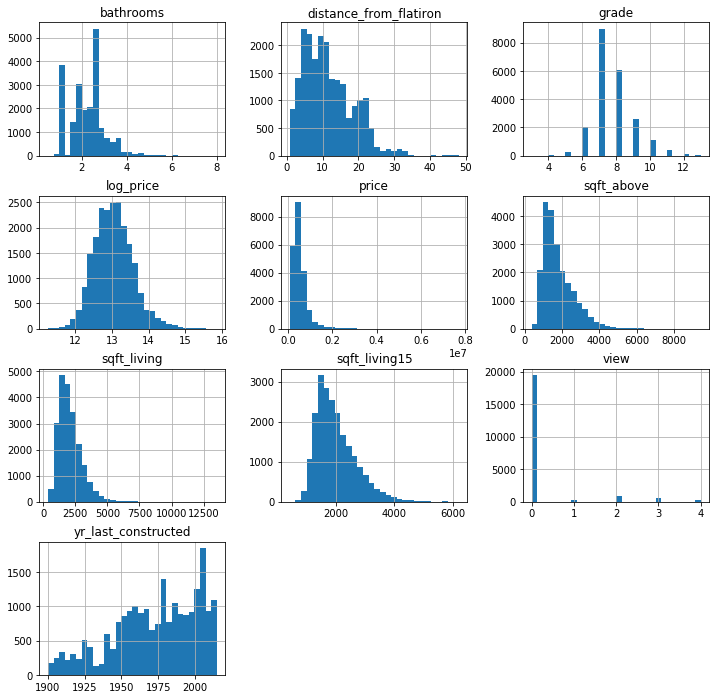

In [51]:
df4.hist(figsize=(12,12),bins=30);

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


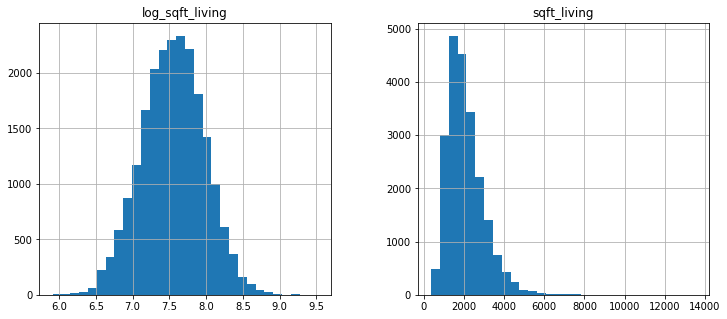

In [52]:
#Engineer the log transformation
df4['log_sqft_living'] = np.log(df4['sqft_living'])

#Plot histograms to compare the original vs. log transformed version of variable
df4[['sqft_living', 'log_sqft_living']].hist(figsize=(12,5),bins=30);

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


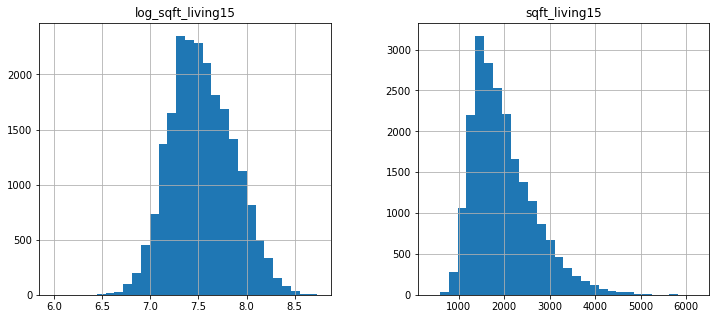

In [53]:
#Engineer the log transformation
df4['log_sqft_living15'] = np.log(df4['sqft_living15'])

#Plot histograms to compare the original vs. log transformed version of variable
df4[['sqft_living15', 'log_sqft_living15']].hist(figsize=(12,5),bins=30);

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


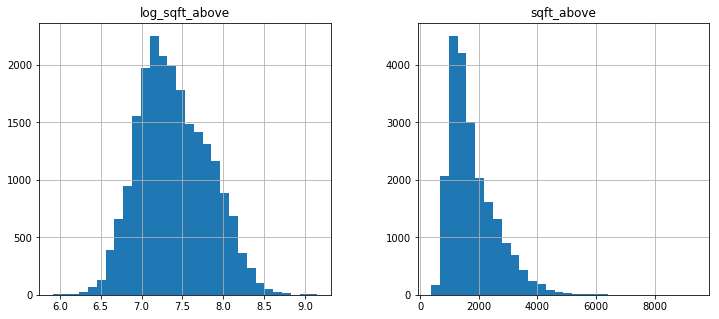

In [54]:
#Engineer the log transformation
df4['log_sqft_above'] = np.log(df4['sqft_above'])

#Plot histograms to compare the original vs. log transformed version of variable
df4[['sqft_above', 'log_sqft_above']].hist(figsize=(12,5),bins=30);

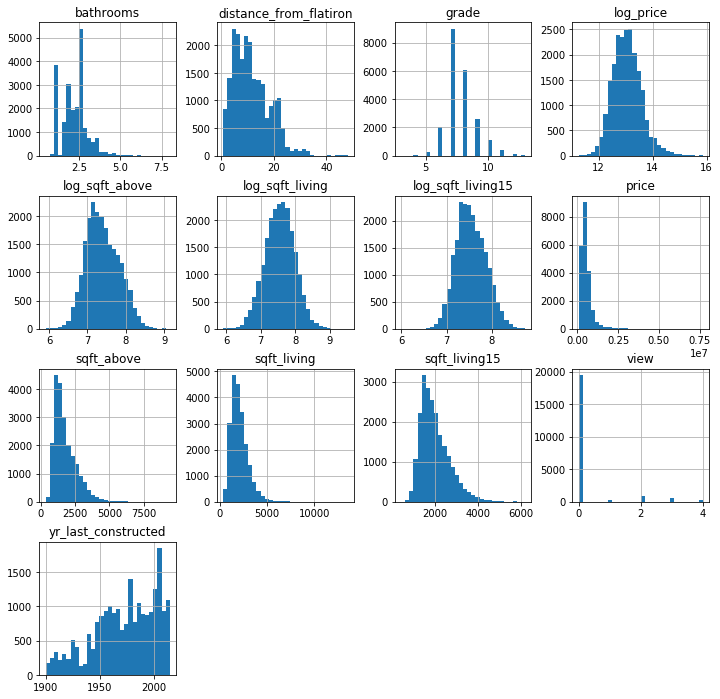

In [55]:
#Re-visualize all of our current models original & log transformed variables
df4.hist(figsize=(12,12),bins=30);

In [56]:
df4.head().T

,0,1,2,3,4
price,221900.000000,538000.000000,180000.000000,604000.000000,510000.000000
log_price,12.309982,13.195614,12.100712,13.311329,13.142166
sqft_living,1180.000000,2570.000000,770.000000,1960.000000,1680.000000
grade,7.000000,7.000000,6.000000,7.000000,8.000000
sqft_above,1180.000000,2170.000000,770.000000,1050.000000,1680.000000
sqft_living15,1340.000000,1690.000000,2720.000000,1360.000000,1800.000000
bathrooms,1.000000,2.250000,1.000000,3.000000,2.000000
view,0.000000,0.000000,0.000000,0.000000,0.000000
distance_from_flatiron,7.714868,7.766476,10.107949,6.655340,13.578402
yr_last_constructed,1955.000000,1991.000000,1933.000000,1965.000000,1987.000000


In [57]:
#drop original columns for those features that were log transformed to prep for next test
df5 = df4.drop(columns=['sqft_above','sqft_living','sqft_living15'])

## Log Transformation Observations:

- sqft_living, sqft_living15, and sqft_above benefitted from a log transformation. All 3 variables transformed become closer to a normal distribution
- We will opt to add in 3 log-transformed independent variables in our next test, log_sqft_living, & log_sqft_living15, and log_sqft_above for our next test, Test 5.


## Test 5: Utilizing Log Transformations of 3x Independent Variables

In [58]:
df5.head().T #just want to double check columns & some values

#EXPECTED COLUMNS:
#['price','log_price','log_sqft_living', 'grade', 'log_sqft_above', 'log_sqft_living15', 'bathrooms',
#    'view','distance_from_flatiron','yr_last_constructed']

,0,1,2,3,4
price,221900.000000,538000.000000,180000.000000,604000.000000,510000.000000
log_price,12.309982,13.195614,12.100712,13.311329,13.142166
grade,7.000000,7.000000,6.000000,7.000000,8.000000
bathrooms,1.000000,2.250000,1.000000,3.000000,2.000000
view,0.000000,0.000000,0.000000,0.000000,0.000000
distance_from_flatiron,7.714868,7.766476,10.107949,6.655340,13.578402
yr_last_constructed,1955.000000,1991.000000,1933.000000,1965.000000,1987.000000
log_sqft_living,7.073270,7.851661,6.646391,7.580700,7.426549
log_sqft_living15,7.200425,7.432484,7.908387,7.215240,7.495542
log_sqft_above,7.073270,7.682482,6.646391,6.956545,7.426549


In [59]:
#statsmodels output
statsmodels_lin_regress_summary(df5)

Our list of predictors: Index(['grade', 'bathrooms', 'view', 'distance_from_flatiron',
       'yr_last_constructed', 'log_sqft_living', 'log_sqft_living15',
       'log_sqft_above'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     7668.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:58:28   Log-Likelihood:                -2258.4
No. Observations:               21597   AIC:                             4535.
Df Residuals:                   21588   BIC:                             4607.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
     

In [60]:
#sci-kit learn output
sklearn_lin_regress_summary(df5)

Results of Sklearn's Train-Test-Split below:
Our list of predictors: Index(['grade', 'bathrooms', 'view', 'distance_from_flatiron',
       'yr_last_constructed', 'log_sqft_living', 'log_sqft_living15',
       'log_sqft_above'],
      dtype='object')
R-squared:0.7491079871479621
Mean Absolute Error (MAE): 110101.86619625952
Mean Squared Error (MSE): 31719806743.604946
Root Mean Squared Error (RMSE): $178100.55233941568


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [61]:
#k-folds cross validation output
k_folds_error_summary(df5,5)

Our list of predictors: Index(['grade', 'bathrooms', 'view', 'distance_from_flatiron',
       'yr_last_constructed', 'log_sqft_living', 'log_sqft_living15',
       'log_sqft_above'],
      dtype='object')
Our R-Squared when k=5 is:0.7383817579393464
 Our average training MAE when k=5 is:110794.59299243032
 Our average training MSE when k=5 is:32853802706.76989
 Our average training RMSE when k=5 is:181256.17977539383


###### Benchmark Errors (before):
- statsmodels R-squared: 0.735
- sci-kit learn R-squared: 0.744
- k=5 kfolds mean R-squared: 0.733
- sci-kit learn MAE: 114,682
- k=5 kfolds mean MAE: 114,092
- sci-kit learn RMSE: 208,953
- k=5 kfolds mean RMSE: 200,281

###### New Errors (after):
- statsmodels R-squared: 0.740
- sci-kit learn R-squared: 0.749
- k=5 kfolds mean R-squared: 0.738
- sci-kit learn MAE: 110,101
- k=5 kfolds mean MAE: 110,794
- sci-kit learn RMSE: 178,100
- k=5 kfolds mean RMSE: 181,256

###### Observations:
- Test 5 improved our model slightly in every key error metric. We will keep each 'log_sqft_living', 'log_sqft_living15','log_sqft_above' in our model going forward.

## Test 6: Add & Test 'distance_from_epicenter' (manually engineered), 'sqft_lot15', and 'waterfront', dropped distance_from_flatiron
- This new feature will now incorporate distances from bellevue, and we created a new column named "distance_from_epicenter" to give the shortest distance from either Seattle or Bellevue, two of the major cities of the area. We dropped 'distance_from_flatiron' to eliminate some redudant implicit information.
- We also added sqft_lot15 & waterfront to capture some unique features of Seattle's housing market that we believe would increase price, the presence of a waterfront view, and houses whose 15 closest neighbors may feature large lots of land.

In [62]:
df5.head().T

,0,1,2,3,4
price,221900.000000,538000.000000,180000.000000,604000.000000,510000.000000
log_price,12.309982,13.195614,12.100712,13.311329,13.142166
grade,7.000000,7.000000,6.000000,7.000000,8.000000
bathrooms,1.000000,2.250000,1.000000,3.000000,2.000000
view,0.000000,0.000000,0.000000,0.000000,0.000000
distance_from_flatiron,7.714868,7.766476,10.107949,6.655340,13.578402
yr_last_constructed,1955.000000,1991.000000,1933.000000,1965.000000,1987.000000
log_sqft_living,7.073270,7.851661,6.646391,7.580700,7.426549
log_sqft_living15,7.200425,7.432484,7.908387,7.215240,7.495542
log_sqft_above,7.073270,7.682482,6.646391,6.956545,7.426549


In [63]:
#load dataset engineered in location_engineering.ipynb
df_water_sqftlot_epicenter = pd.read_csv('last_test.csv')

#drop columns that won't be concatenated
df_water_sqftlot_epicenter = df_water_sqftlot_epicenter.drop(columns=[
    'log_price', 'log_sqft_living', 'grade', 'log_sqft_living15',
    'bathrooms', 'view', 'yr_last_constructed', '98001', '98002', '98003', '98004', '98005',
    '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022',
    '98023', '98024', '98027', '98028', '98029', '98030', '98031', '98032',
    '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98052',
    '98053', '98055', '98056', '98058', '98059', '98065', '98070', '98072',
    '98074', '98075', '98077', '98092', '98102', '98103', '98105', '98106',
    '98107', '98108', '98109', '98112', '98115', '98116', '98117', '98118',
    '98119', '98122', '98125', '98126', '98133', '98136', '98144', '98146',
    '98148', '98155', '98166', '98168', '98177', '98178', '98188', '98198',
    '98199'])

#see remaining columns to be concatenated
df_water_sqftlot_epicenter.columns

Index(['waterfront', 'sqft_lot15', 'distance_from_epicenter'], dtype='object')

In [64]:
df6 = pd.concat([df5, df_water_sqftlot_epicenter], axis=1)

In [65]:
df6.head().T

,0,1,2,3,4
price,221900.000000,538000.000000,180000.000000,604000.000000,510000.000000
log_price,12.309982,13.195614,12.100712,13.311329,13.142166
grade,7.000000,7.000000,6.000000,7.000000,8.000000
bathrooms,1.000000,2.250000,1.000000,3.000000,2.000000
view,0.000000,0.000000,0.000000,0.000000,0.000000
distance_from_flatiron,7.714868,7.766476,10.107949,6.655340,13.578402
yr_last_constructed,1955.000000,1991.000000,1933.000000,1965.000000,1987.000000
log_sqft_living,7.073270,7.851661,6.646391,7.580700,7.426549
log_sqft_living15,7.200425,7.432484,7.908387,7.215240,7.495542
log_sqft_above,7.073270,7.682482,6.646391,6.956545,7.426549


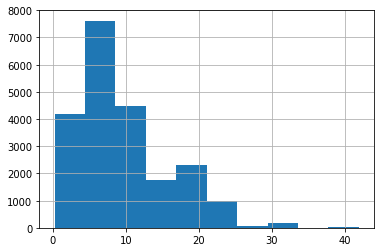

In [107]:
df6['distance_from_epicenter'].hist();

In [66]:
#statsmodels output
statsmodels_lin_regress_summary(df6)

Our list of predictors: Index(['grade', 'bathrooms', 'view', 'distance_from_flatiron',
       'yr_last_constructed', 'log_sqft_living', 'log_sqft_living15',
       'log_sqft_above', 'waterfront', 'sqft_lot15',
       'distance_from_epicenter'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     7232.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:58:29   Log-Likelihood:                -114.40
No. Observations:               21597   AIC:                             252.8
Df Residuals:                   21585   BIC:                             348.6
Df Model:                          11                                         
Covariance Type:      

In [67]:
#sci-kit learn output
sklearn_lin_regress_summary(df6)

Results of Sklearn's Train-Test-Split below:
Our list of predictors: Index(['grade', 'bathrooms', 'view', 'distance_from_flatiron',
       'yr_last_constructed', 'log_sqft_living', 'log_sqft_living15',
       'log_sqft_above', 'waterfront', 'sqft_lot15',
       'distance_from_epicenter'],
      dtype='object')
R-squared:0.7932902288051557
Mean Absolute Error (MAE): 100301.2023057508
Mean Squared Error (MSE): 29243129974.700497
Root Mean Squared Error (RMSE): $171006.2278827894


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [68]:
#k-folds cross validation output
k_folds_error_summary(df6,5)

Our list of predictors: Index(['grade', 'bathrooms', 'view', 'distance_from_flatiron',
       'yr_last_constructed', 'log_sqft_living', 'log_sqft_living15',
       'log_sqft_above', 'waterfront', 'sqft_lot15',
       'distance_from_epicenter'],
      dtype='object')
Our R-Squared when k=5 is:0.7849579500150929
 Our average training MAE when k=5 is:100768.47863528563
 Our average training MSE when k=5 is:28718569502.29902
 Our average training RMSE when k=5 is:169465.54075179715


###### Benchmark Errors (before):
- statsmodels R-squared: 0.740
- sci-kit learn R-squared: 0.749
- k=5 kfolds mean R-squared: 0.738
- sci-kit learn MAE: 110,101
- k=5 kfolds mean MAE: 110,794
- sci-kit learn RMSE: 178,100
- k=5 kfolds mean RMSE: 181,256

###### New Errors (after):
- statsmodels R-squared: 0.787
- sci-kit learn R-squared: 0.793
- k=5 kfolds mean R-squared: 0.784
- sci-kit learn MAE: 100,301
- k=5 kfolds mean MAE: 100,768
- sci-kit learn RMSE: 171,006
- k=5 kfolds mean RMSE: 169,465

###### Observations:
- Test 6 improved our model in every key error metric. We will keep distances_from_epicenter, sqft_lot15, and waterfront in our model.

## Test 7: pd.get_dummies on 'zipcode' to capture all information contained within zipcode categories in prediction, & add to current model from Test 6

In [69]:
df_zip_dums = pd.get_dummies(df['zipcode'])
df7 = pd.concat([df6, df_zip_dums], axis=1)
df7.head().T

,0,1,2,3,4
price,221900.000000,538000.000000,180000.000000,604000.000000,510000.000000
log_price,12.309982,13.195614,12.100712,13.311329,13.142166
grade,7.000000,7.000000,6.000000,7.000000,8.000000
bathrooms,1.000000,2.250000,1.000000,3.000000,2.000000
view,0.000000,0.000000,0.000000,0.000000,0.000000
distance_from_flatiron,7.714868,7.766476,10.107949,6.655340,13.578402
yr_last_constructed,1955.000000,1991.000000,1933.000000,1965.000000,1987.000000
log_sqft_living,7.073270,7.851661,6.646391,7.580700,7.426549
log_sqft_living15,7.200425,7.432484,7.908387,7.215240,7.495542
log_sqft_above,7.073270,7.682482,6.646391,6.956545,7.426549


In [70]:
#Drop a single column post-.get_dummies() to eliminate information redundancy
df7 = df7.drop(columns=[98103])

We decided to drop ZipCode: 98103, which is representative of the area surrounding Green Lake on the north side of Seattle, which will help our analysis because:
- It will act as a benchmark with which we can interpret the remaining Zip Code model coefficients
- It is a well-known area in Greater Seattle/King County that we believe will carry relevant context to listeners as we communicate to project stakeholders (in other words, we believe people are aware of this area and possibly some of it's characteristics)
- It is not too far removed from the median zip code when ranking zip code groups by average home price, so we expect to have a decent amount of coefficients on either side of 0 in our summary output (in other words, lots of zip codes contain higher avg. home prices, and lots of zip codes contain lower avg. home prices)

In [71]:
statsmodels_lin_regress_summary(df7)

Our list of predictors: Index([                  'grade',               'bathrooms',
                          'view',  'distance_from_flatiron',
           'yr_last_constructed',         'log_sqft_living',
             'log_sqft_living15',          'log_sqft_above',
                    'waterfront',              'sqft_lot15',
       'distance_from_epicenter',                     98001,
                           98002,                     98003,
                           98004,                     98005,
                           98006,                     98007,
                           98008,                     98010,
                           98011,                     98014,
                           98019,                     98022,
                           98023,                     98024,
                           98027,                     98028,
                           98029,                     98030,
                           98031,                     98032,


In [72]:
#Zip Codes to drop due to p-value > 0.05
print(df7.columns[56+1])

98107


##### Oh no! After dropping the zip codes with p-values > 0.05, our linear model outputs even more zip codes with p-values > 0.05. 
##### Instead of continuing to drop more columns with p-values >0.05, we will use our original model with only the benchmark zip code 98103 dropped, while keeping our above-threshold p-value Zip Code 98107 in the data set. 
##### Without fully understanding the root cause of this, we will simply have to be careful when it comes to interpreting those zip codes that remain with high p-values.

In [73]:
sklearn_lin_regress_summary(df7)

Results of Sklearn's Train-Test-Split below:
Our list of predictors: Index([                  'grade',               'bathrooms',
                          'view',  'distance_from_flatiron',
           'yr_last_constructed',         'log_sqft_living',
             'log_sqft_living15',          'log_sqft_above',
                    'waterfront',              'sqft_lot15',
       'distance_from_epicenter',                     98001,
                           98002,                     98003,
                           98004,                     98005,
                           98006,                     98007,
                           98008,                     98010,
                           98011,                     98014,
                           98019,                     98022,
                           98023,                     98024,
                           98027,                     98028,
                           98029,                     98030,
                

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [74]:
k_folds_error_summary(df7,5)

Our list of predictors: Index([                  'grade',               'bathrooms',
                          'view',  'distance_from_flatiron',
           'yr_last_constructed',         'log_sqft_living',
             'log_sqft_living15',          'log_sqft_above',
                    'waterfront',              'sqft_lot15',
       'distance_from_epicenter',                     98001,
                           98002,                     98003,
                           98004,                     98005,
                           98006,                     98007,
                           98008,                     98010,
                           98011,                     98014,
                           98019,                     98022,
                           98023,                     98024,
                           98027,                     98028,
                           98029,                     98030,
                           98031,                     98032,


###### Benchmark Errors (before):
- statsmodels R-squared: 0.740
- sci-kit learn R-squared: 0.749
- k=5 kfolds mean R-squared: 0.738
- sci-kit learn MAE: 110,101
- k=5 kfolds mean MAE: 110,794
- sci-kit learn RMSE: 178,100
- k=5 kfolds mean RMSE: 181,256

###### New Errors (after):
- statsmodels R-squared: 0.877
- sci-kit learn R-squared: 0.879
- k=5 kfolds mean R-squared: 0.875
- sci-kit learn MAE: 74,434
- k=5 kfolds mean MAE: 74,562
- sci-kit learn RMSE: 137,470
- k=5 kfolds mean RMSE: 133,034

###### Observations:
- Test 7 improved our model significantly in every key error metric. We will keep each categorical zip code as a column after utilizing the .get_dummies() method and dropping the Zip Code 98103 (near Green Lake). 
- As previously explained, dropping high p-value zip codes sends us into a rabbit hole of generating more high p-value zip codes, so we will opt for the model with the smallest number of these, our original version post-dropping Green Lake (98103).

#### Interpreting Coefficients:
- distance_from_epicenter: -0.0285
    - the expected percent decrease in geometric mean of Price(y) for every mile further the house is away from the nearest of Bellevue or Downtown Seattle is about 3% holding other variables constant, since e^(distance_from_epicenter coefficient)≈0.97

- bathrooms: 0.0274
    - the expected percent increase in geometric mean of Price(y) for every additional bathroom the house has is about 2.7% holding other variables constant, since e^(bathrooms coefficient)≈1.027

- grade: 0.0940
    - the expected percent increase in geometric mean of Price(y) for every 1 point increase in grade the house received is about 9.8% holding other variables constant, since e^(grade coefficient)≈1.098
